## Import Data

In [1]:
import os
import shutil

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
# from tensorflow.keras import callbacks
# from tensorflow.keras import models
# from tensorflow.keras import layers
# from tensorflow.keras import losses



In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [4]:
categories = os.listdir('data/raw')
categories

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [5]:
image_paths = {}
for cat in categories:
    image_paths[cat] = os.listdir(os.path.join('data/raw',cat))
    print('There are', len(os.listdir(os.path.join('data/raw',cat))), cat, 'images' )
    

There are 594 paper images
There are 410 metal images
There are 403 cardboard images
There are 137 trash images
There are 501 glass images
There are 482 plastic images


This dataset is small.  We will need to augment it but lets start with this.  This is the trashnet dataset from Mindy Yang and Gary Thung.

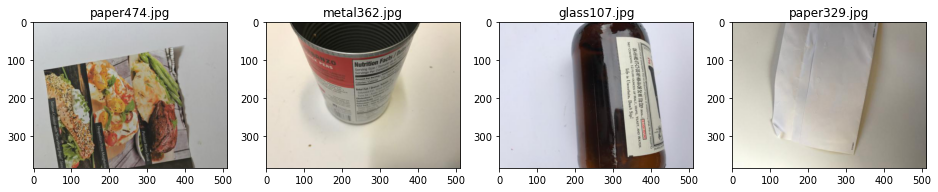

In [6]:
# inspect random images
fig, axs = plt.subplots(1,4, figsize=(16,4))
                        
for ax in axs:
    cat = np.random.choice(categories)
    file_name = np.random.choice(os.listdir(os.path.join('data/raw',cat)))
    img = load_img(os.path.join('data/raw',cat,file_name))
    ax.imshow(img)
    ax.set_title(file_name)

In [7]:
#The current dimentions of the files are 512, 384
#that means 
512 * 384 * 3
#inputs

589824

Lets try and see what happens.

## Split into train, validation, test

In [8]:
# set proportion of each class to hold for validation and testing.
val_portion = 0.05
test_portion = 0.05

split_base = 'data/split'

# remove the folder if it exists and rerun the split
if os.path.isdir(split_base):
    shutil.rmtree(split_base)

os.mkdir(split_base)

# store the path of each folder and create directories
train_folder = os.path.join(split_base, 'train')
os.mkdir(train_folder)

val_folder = os.path.join(split_base, 'validation')
os.mkdir(val_folder)

test_folder = os.path.join(split_base, 'test')
os.mkdir(test_folder)



In [9]:

for cat in categories:
    # randomize the file order
    np.random.shuffle(image_paths[cat])
    num_files = len(image_paths[cat])
    
    # set split boundries for validation and test
    validation_boundry = int(np.floor(num_files * val_portion))
    test_boundry = int(np.floor(num_files * test_portion) + validation_boundry)
        
    # store boundries
    labels = {'validation': image_paths[cat][:validation_boundry],
              'test': image_paths[cat][validation_boundry:test_boundry],
              'train': image_paths[cat][test_boundry:]}
    
    # loop through boundries and move copy files
    for label, files in labels.items():
        # create folder
        os.mkdir(os.path.join(split_base, label, cat))
        
        for file in files:
            shutil.copyfile(os.path.join('data/raw', cat, file),
                            os.path.join(split_base, label, cat, file))


In [10]:
[ f.path for f in os.scandir(split_base) if f.is_dir() ]


['data/split/test', 'data/split/train', 'data/split/validation']

In [11]:
os.walk(train_folder)

<generator object walk at 0x106cb1550>

In [12]:
# Check number of files in each folder

def count_files(folder):
    '''Counts all files in subdirectories a give directory
    
    Parameters:
    -----------
    folder: The directory to containing the files to count
    
    Returns:
    --------
    count:  int. The number of files not include folders, but incuding all 
    subdirectories in the given path.
    '''
    paths = [path for path, subdirs, files in os.walk(folder) if path != folder]
    num = 0
    for path in paths:
        num += len(os.listdir(path))
    return num

num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)



# # Check number of files in each folder
# paths = [path for path, subdirs, files in os.walk(train_folder) if path != train_folder]
# num_train = 0
# for path in paths:
#     print(len(os.listdir(path)))
#     num_train += len(os.listdir(path))

In [13]:
print('Total training files:', num_train)
print('Total validation files:', num_val)
print('Total testing files:', num_test)


Total training files: 2279
Total validation files: 124
Total testing files: 124


I want the training size to be divisible by 32.  The closest number divisible by 2 is 2272 so I would need to move 7 files to the validation and/or testing classes.  To make things easy I will move it to validation.

In [14]:
folders = [(f.path, len(os.listdir(f.path))) for f in os.scandir(train_folder) if f.is_dir() ]
folders = sorted(folders, key=lambda x: x[1], reverse=True)

for i in range(7):
    # set the index of the folder to move from.
    i = i % 6
    from_dir = folders[i][0]
    # choose a random file from this folder
    file = np.random.choice(os.listdir(from_dir))
    to_dir = from_dir.replace('/train/', '/validation/')
    
    print(f'Moving {file} from {from_dir} to {to_dir}')
    shutil.move(os.path.join(from_dir, file), os.path.join(to_dir, file))

Moving paper270.jpg from data/split/train/paper to data/split/validation/paper
Moving glass204.jpg from data/split/train/glass to data/split/validation/glass
Moving plastic110.jpg from data/split/train/plastic to data/split/validation/plastic
Moving metal268.jpg from data/split/train/metal to data/split/validation/metal
Moving cardboard284.jpg from data/split/train/cardboard to data/split/validation/cardboard
Moving trash99.jpg from data/split/train/trash to data/split/validation/trash
Moving paper484.jpg from data/split/train/paper to data/split/validation/paper


In [15]:
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)
print('Total training files:', num_train)
print('Total validation files:', num_val)
print('Total testing files:', num_test)

Total training files: 2272
Total validation files: 131
Total testing files: 124
